# LEGO Business Intelligence: Strategic Insights & Market Analysis

## 📖 Overview

This notebook delivers business intelligence insights through advanced SQL analysis of LEGO product data.

**Focus Areas:**
- Theme hierarchy and market share
- Product portfolio performance scoring
- Strategic recommendations
- Competitive positioning analysis

**SQL Techniques Demonstrated:**
- Recursive CTEs for hierarchical data
- Multi-CTE complex queries
- Composite scoring algorithms
- Market share calculations
- Strategic segmentation

**Prerequisites:** Database from `01_Database_Setup.ipynb`

---

## 1. Setup & Database Connection

In [7]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("✅ Libraries imported!")

✅ Libraries imported!


In [8]:
# Connect to database
DB_NAME = '/content/lego_analysis.db'
conn = sqlite3.connect(DB_NAME)

print(f"✅ Connected to {DB_NAME}")

# Quick verification
stats = pd.read_sql("""
    SELECT
        COUNT(DISTINCT set_num) as sets,
        COUNT(DISTINCT theme_id) as themes,
        MIN(year) as min_year,
        MAX(year) as max_year
    FROM sets
""", conn)

print(f"📊 Database Stats:")
print(f"   Sets: {stats['sets'].iloc[0]:,}")
print(f"   Themes: {stats['themes'].iloc[0]:,}")
print(f"   Years: {stats['min_year'].iloc[0]}-{stats['max_year'].iloc[0]}")

✅ Connected to /content/lego_analysis.db
📊 Database Stats:
   Sets: 9,999
   Themes: 230
   Years: 2015-2024


---

## 2. Theme Hierarchy Analysis

### Query 1: Recursive Theme Hierarchy

**Business Question:** How do parent and child themes perform across the hierarchy?

**SQL Techniques:**
- Recursive CTE for hierarchical navigation
- Multi-level aggregation
- Path construction

In [9]:
query_hierarchy = """
WITH RECURSIVE theme_hierarchy AS (
    -- Base case: root themes (no parent)
    SELECT
        id,
        name,
        parent_id,
        name AS root_theme,
        0 AS level,
        name AS path
    FROM themes
    WHERE parent_id IS NULL

    UNION ALL

    -- Recursive case: child themes
    SELECT
        t.id,
        t.name,
        t.parent_id,
        th.root_theme,
        th.level + 1,
        th.path || ' > ' || t.name
    FROM themes t
    JOIN theme_hierarchy th ON t.parent_id = th.id
    WHERE th.level < 3  -- Limit recursion depth
)
SELECT
    th.root_theme,
    th.name AS sub_theme,
    th.level,
    th.path,
    COUNT(s.set_num) AS set_count,
    ROUND(AVG(s.num_parts), 2) AS avg_parts,
    SUM(s.num_parts) AS total_parts
FROM theme_hierarchy th
LEFT JOIN sets s ON th.id = s.theme_id
WHERE s.year >= 2020  -- Focus on recent years
GROUP BY th.root_theme, th.name, th.level, th.path
HAVING COUNT(s.set_num) > 0
ORDER BY th.root_theme, th.level, set_count DESC
LIMIT 50
"""

df_hierarchy = pd.read_sql(query_hierarchy, conn)

print("📊 Theme Hierarchy Analysis (2020-2024)\n")
print("="*120)
display(df_hierarchy)

print("\n🔍 Hierarchy Insights:")
print(f"   • Root themes represented: {df_hierarchy['root_theme'].nunique()}")
print(f"   • Max hierarchy depth: {df_hierarchy['level'].max()}")
print(f"   • Most prolific sub-theme: {df_hierarchy.loc[df_hierarchy['set_count'].idxmax(), 'sub_theme']} ({df_hierarchy['set_count'].max()} sets)")

📊 Theme Hierarchy Analysis (2020-2024)



,root_theme,sub_theme,level,path,set_count,avg_parts,total_parts
0,Animal Crossing,Animal Crossing,0,Animal Crossing,10,249.90,2499
1,Architecture,Architecture,0,Architecture,6,1939.50,11637
2,Architecture,Skylines,1,Architecture > Skylines,3,705.67,2117
3,Avatar,Avatar,0,Avatar,9,614.33,5529
4,Books,Activity Books with LEGO Parts,1,Books > Activity Books with LEGO Parts,69,12.55,866
5,Books,Story Books,1,Books > Story Books,46,2.17,100
6,Books,Ideas Books,1,Books > Ideas Books,41,24.12,989
7,Books,Non-fiction Books,1,Books > Non-fiction Books,38,2.50,95
8,Books,Activity Books,1,Books > Activity Books,30,0.00,0
9,Books,Technic,1,Books > Technic,1,62.00,62



🔍 Hierarchy Insights:
   • Root themes represented: 13
   • Max hierarchy depth: 1
   • Most prolific sub-theme: City (94 sets)


---

## 3. Market Share Analysis

### Query 2: Theme Market Share Over Time

**Business Question:** How has market share shifted among top themes?

**SQL Techniques:**
- Window functions for percentage calculations
- PARTITION BY year for annual comparisons
- Market share trending

In [10]:
query_market_share = """
WITH theme_yearly AS (
    SELECT
        s.year,
        t.name AS theme,
        COUNT(s.set_num) AS sets_count,
        SUM(s.num_parts) AS total_parts
    FROM sets s
    JOIN themes t ON s.theme_id = t.id
    WHERE s.year BETWEEN 2020 AND 2024
    GROUP BY s.year, t.name
),
ranked_themes AS (
    SELECT
        year,
        theme,
        sets_count,
        total_parts,
        RANK() OVER (PARTITION BY year ORDER BY sets_count DESC) AS rank_by_sets,
        ROUND(sets_count * 100.0 / SUM(sets_count) OVER (PARTITION BY year), 2) AS market_share_pct,
        ROUND(total_parts * 100.0 / SUM(total_parts) OVER (PARTITION BY year), 2) AS parts_share_pct
    FROM theme_yearly
)
SELECT
    year,
    theme,
    sets_count,
    rank_by_sets,
    market_share_pct,
    parts_share_pct,
    total_parts
FROM ranked_themes
WHERE rank_by_sets <= 10  -- Top 10 themes per year
ORDER BY year DESC, rank_by_sets
"""

df_market_share = pd.read_sql(query_market_share, conn)

print("📊 Top 10 Themes by Market Share (2020-2024)\n")
print("="*100)
display(df_market_share)

print("\n🔍 Market Share Insights:")
# Get 2024 top theme
top_2024 = df_market_share[df_market_share['year'] == 2024].iloc[0]
print(f"   • 2024 market leader: {top_2024['theme']} ({top_2024['market_share_pct']:.1f}% share)")
print(f"   • 2024 top 3 control: {df_market_share[df_market_share['year'] == 2024].head(3)['market_share_pct'].sum():.1f}% of market")

📊 Top 10 Themes by Market Share (2020-2024)



,year,theme,sets_count,rank_by_sets,market_share_pct,parts_share_pct,total_parts
0,2024,"Bags, Totes, & Luggage",75,1,7.5,0.00,0
1,2024,Gear,57,2,5.7,0.00,0
2,2024,Stationery and Office Supplies,55,3,5.5,0.00,2
3,2024,Friends,50,4,5.0,6.00,18417
4,2024,Star Wars,40,5,4.0,5.74,17624
...,...,...,...,...,...,...,...
47,2020,Key Chain,29,7,2.9,0.02,47
48,2020,Role Play Toys and Costumes,24,8,2.4,0.00,0
49,2020,Storage,23,9,2.3,0.01,20
50,2020,Activity Books,22,10,2.2,0.00,0



🔍 Market Share Insights:
   • 2024 market leader: Bags, Totes, & Luggage (7.5% share)
   • 2024 top 3 control: 18.7% of market


### Visualization: Market Share Trends

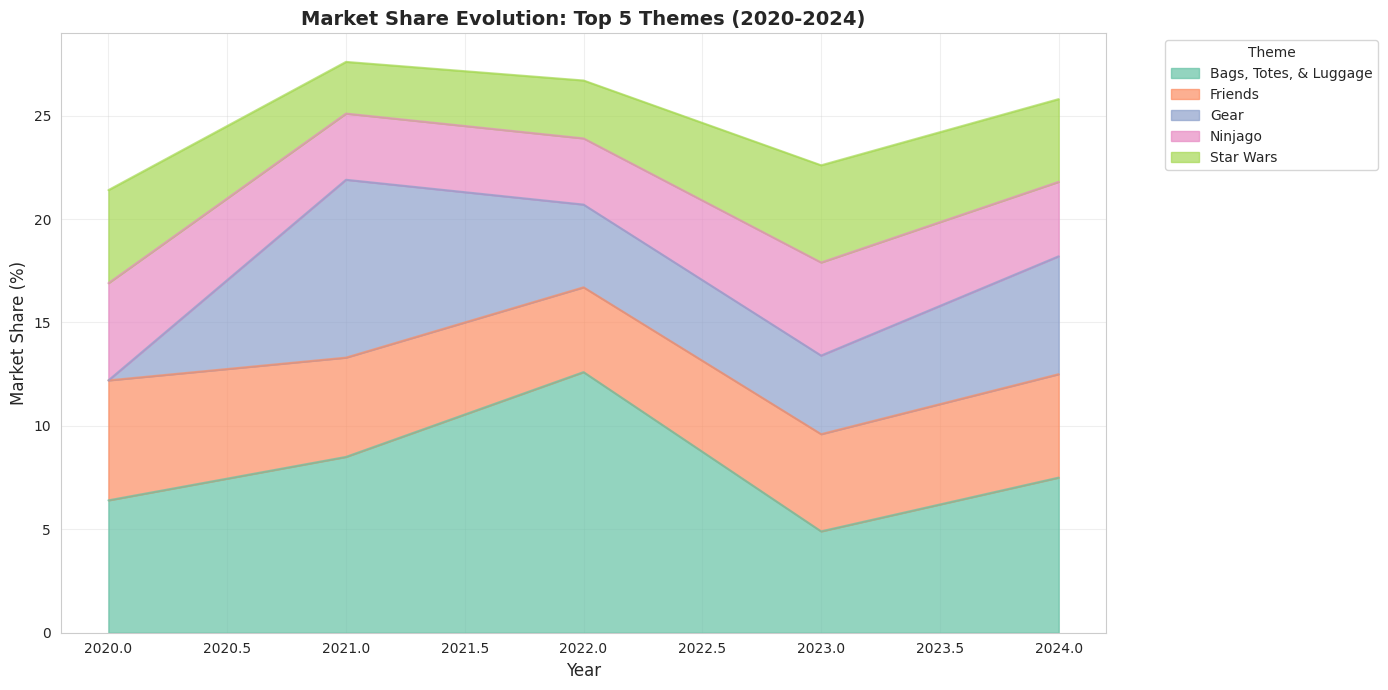

📊 Stacked area chart shows relative market share changes over time


In [11]:
# Get top 5 themes across all years
top_themes = df_market_share.groupby('theme')['sets_count'].sum().nlargest(5).index.tolist()

# Filter for top themes
df_plot = df_market_share[df_market_share['theme'].isin(top_themes)].copy()

# Pivot for plotting
pivot_data = df_plot.pivot(index='year', columns='theme', values='market_share_pct').fillna(0)

# Create stacked area chart
fig, ax = plt.subplots(figsize=(14, 7))
pivot_data.plot(kind='area', stacked=True, alpha=0.7, ax=ax)

ax.set_title('Market Share Evolution: Top 5 Themes (2020-2024)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Market Share (%)', fontsize=12)
ax.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Stacked area chart shows relative market share changes over time")

---

## 4. Theme Performance Scorecard

### Query 3: Comprehensive Theme Performance Score

**Business Question:** Which themes represent the best overall portfolio performance?

**Scoring Methodology:**
- Longevity: 30 points (years active)
- Volume: 40 points (number of sets)
- Complexity: 30 points (average parts)

**SQL Techniques:**
- Multi-CTE analysis
- Composite scoring algorithm
- Multiple ranking dimensions

In [12]:
query_scorecard = """
WITH theme_metrics AS (
    SELECT
        t.id,
        t.name AS theme,
        COUNT(DISTINCT s.set_num) AS total_sets,
        COUNT(DISTINCT s.year) AS years_active,
        MIN(s.year) AS first_year,
        MAX(s.year) AS last_year,
        ROUND(AVG(s.num_parts), 2) AS avg_complexity,
        SUM(s.num_parts) AS total_parts,
        MAX(s.num_parts) AS max_complexity
    FROM themes t
    LEFT JOIN sets s ON t.id = s.theme_id
    WHERE s.year >= 2015
    GROUP BY t.id, t.name
    HAVING COUNT(DISTINCT s.set_num) >= 15  -- Minimum 15 sets
),
theme_scores AS (
    SELECT
        theme,
        total_sets,
        years_active,
        first_year,
        last_year,
        avg_complexity,
        max_complexity,
        -- Longevity score (max 30 points)
        CASE
            WHEN years_active >= 10 THEN 30
            WHEN years_active >= 7 THEN 25
            WHEN years_active >= 5 THEN 20
            WHEN years_active >= 3 THEN 15
            ELSE years_active * 4
        END AS longevity_score,
        -- Volume score (max 40 points)
        CASE
            WHEN total_sets >= 200 THEN 40
            WHEN total_sets >= 100 THEN 35
            WHEN total_sets >= 50 THEN 30
            WHEN total_sets >= 30 THEN 25
            ELSE total_sets * 0.6
        END AS volume_score,
        -- Complexity score (max 30 points)
        CASE
            WHEN avg_complexity >= 800 THEN 30
            WHEN avg_complexity >= 500 THEN 25
            WHEN avg_complexity >= 300 THEN 20
            WHEN avg_complexity >= 200 THEN 15
            ELSE avg_complexity * 0.05
        END AS complexity_score
    FROM theme_metrics
)
SELECT
    theme,
    total_sets,
    years_active,
    first_year,
    last_year,
    avg_complexity,
    max_complexity,
    longevity_score,
    volume_score,
    complexity_score,
    ROUND(longevity_score + volume_score + complexity_score, 2) AS overall_score,
    RANK() OVER (ORDER BY (longevity_score + volume_score + complexity_score) DESC) AS performance_rank,
    NTILE(4) OVER (ORDER BY (longevity_score + volume_score + complexity_score) DESC) AS performance_quartile
FROM theme_scores
ORDER BY overall_score DESC
LIMIT 25
"""

df_scorecard = pd.read_sql(query_scorecard, conn)

print("📊 Theme Performance Scorecard (Top 25)\n")
print("="*120)
display(df_scorecard)

print("\n🔍 Performance Insights:")
print(f"   • Top performer: {df_scorecard.iloc[0]['theme']} ({df_scorecard.iloc[0]['overall_score']:.1f} points)")
print(f"   • Highest longevity: {df_scorecard.loc[df_scorecard['longevity_score'].idxmax(), 'theme']} ({df_scorecard['years_active'].max()} years)")
print(f"   • Highest volume: {df_scorecard.loc[df_scorecard['volume_score'].idxmax(), 'theme']} ({df_scorecard['total_sets'].max()} sets)")
print(f"   • Highest complexity: {df_scorecard.loc[df_scorecard['complexity_score'].idxmax(), 'theme']} ({df_scorecard['avg_complexity'].max():.0f} avg parts)")

📊 Theme Performance Scorecard (Top 25)



,theme,total_sets,years_active,first_year,last_year,avg_complexity,max_complexity,longevity_score,volume_score,complexity_score,overall_score,performance_rank,performance_quartile
0,Technic,161,10,2015,2024,943.34,4108,30,35.0,30.0000,95.00,1,1
1,Star Wars,487,10,2015,2024,320.07,3187,30,40.0,20.0000,90.00,2,1
2,LEGO Ideas and CUUSOO,64,10,2015,2024,1368.75,3955,30,30.0,30.0000,90.00,2,1
3,FIRST LEGO League,31,10,2015,2024,861.61,2179,30,25.0,30.0000,85.00,4,1
4,Ninjago,397,10,2015,2024,287.42,6163,30,40.0,15.0000,85.00,4,1
5,Friends,484,10,2015,2024,248.03,2275,30,40.0,15.0000,85.00,4,1
6,Minecraft,139,10,2015,2024,311.57,2863,30,35.0,20.0000,85.00,4,1
7,Classic,72,10,2015,2024,525.24,1800,30,30.0,25.0000,85.00,4,1
8,Creator 3-in-1,146,10,2015,2024,347.07,1460,30,35.0,20.0000,85.00,4,1
9,City,157,10,2015,2024,270.52,2010,30,35.0,15.0000,80.00,10,1



🔍 Performance Insights:
   • Top performer: Technic (95.0 points)
   • Highest longevity: Technic (10 years)
   • Highest volume: Star Wars (487 sets)
   • Highest complexity: Technic (3463 avg parts)


### Visualization: Performance Scorecard Breakdown

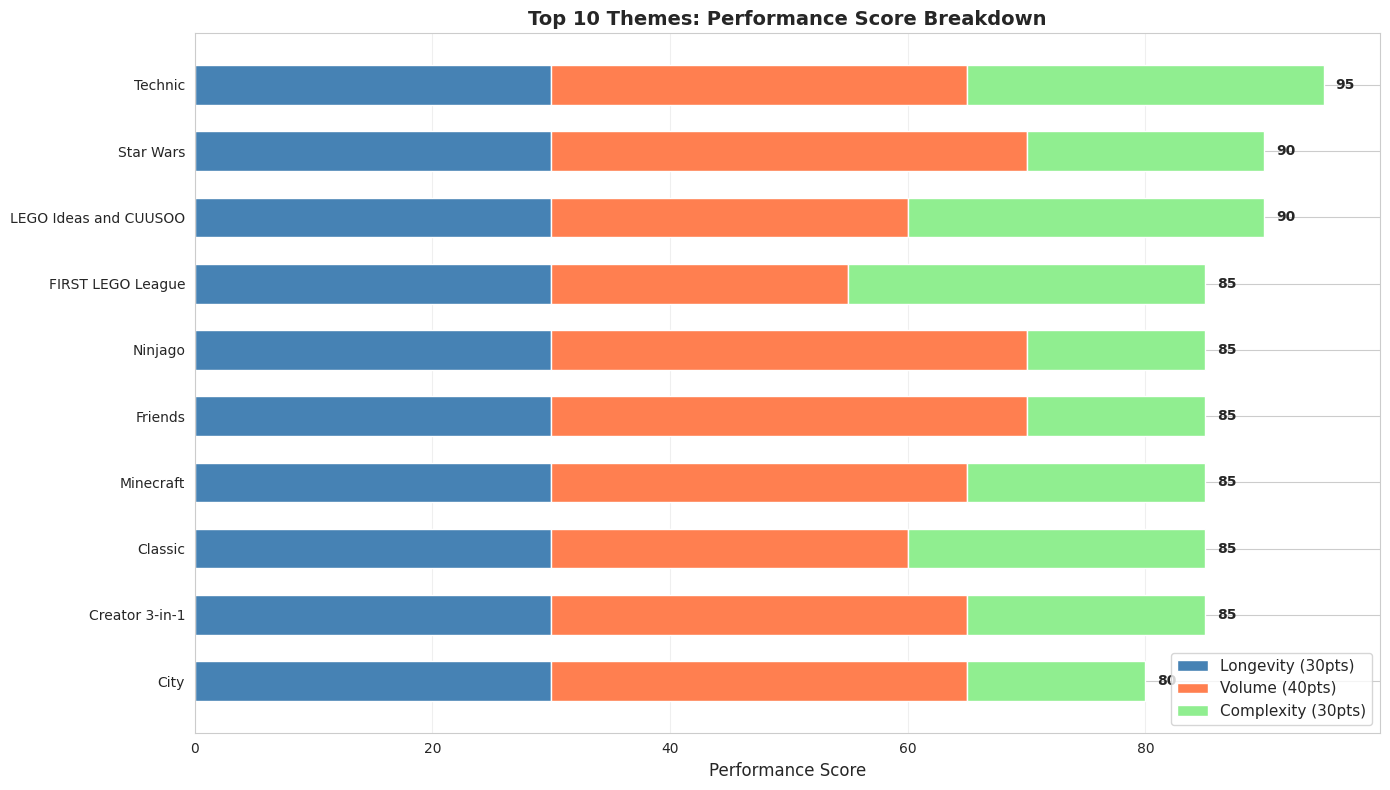

📊 Stacked bars show contribution of each performance dimension to overall score


In [13]:
# Top 10 for visualization
top_10 = df_scorecard.head(10).copy()

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(top_10))
width = 0.6

# Stacked bars
p1 = ax.barh(x, top_10['longevity_score'], width, label='Longevity (30pts)', color='steelblue')
p2 = ax.barh(x, top_10['volume_score'], width, left=top_10['longevity_score'],
             label='Volume (40pts)', color='coral')
p3 = ax.barh(x, top_10['complexity_score'], width,
             left=top_10['longevity_score'] + top_10['volume_score'],
             label='Complexity (30pts)', color='lightgreen')

# Formatting
ax.set_yticks(x)
ax.set_yticklabels(top_10['theme'])
ax.invert_yaxis()
ax.set_xlabel('Performance Score', fontsize=12)
ax.set_title('Top 10 Themes: Performance Score Breakdown', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

# Add total scores as annotations
for i, score in enumerate(top_10['overall_score']):
    ax.text(score + 1, i, f'{score:.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Stacked bars show contribution of each performance dimension to overall score")

---

## 5. Strategic Segmentation

### Query 4: Theme Portfolio Segmentation

**Business Question:** How can we segment themes into strategic categories?

**Segments:**
- **Stars:** High volume + High complexity
- **Workhorses:** High volume + Mid complexity
- **Premium:** Low volume + High complexity
- **Entry:** Low volume + Low complexity

**SQL Techniques:**
- NTILE for quartile grouping
- CASE WHEN for segmentation logic
- Multi-dimensional classification

In [14]:
query_segmentation = """
WITH theme_stats AS (
    SELECT
        t.name AS theme,
        COUNT(s.set_num) AS set_count,
        ROUND(AVG(s.num_parts), 2) AS avg_parts,
        NTILE(2) OVER (ORDER BY COUNT(s.set_num)) AS volume_segment,
        NTILE(2) OVER (ORDER BY AVG(s.num_parts)) AS complexity_segment
    FROM themes t
    JOIN sets s ON t.id = s.theme_id
    WHERE s.year >= 2020
    GROUP BY t.name
    HAVING COUNT(s.set_num) >= 10
)
SELECT
    theme,
    set_count,
    avg_parts,
    volume_segment,
    complexity_segment,
    CASE
        WHEN volume_segment = 2 AND complexity_segment = 2 THEN 'Star'
        WHEN volume_segment = 2 AND complexity_segment = 1 THEN 'Workhorse'
        WHEN volume_segment = 1 AND complexity_segment = 2 THEN 'Premium'
        ELSE 'Entry'
    END AS strategic_segment
FROM theme_stats
ORDER BY
    CASE strategic_segment
        WHEN 'Star' THEN 1
        WHEN 'Workhorse' THEN 2
        WHEN 'Premium' THEN 3
        ELSE 4
    END,
    set_count DESC
"""

df_segments = pd.read_sql(query_segmentation, conn)

print("📊 Theme Portfolio Segmentation (2020-2024)\n")
print("="*100)
display(df_segments)

# Segment summary
print("\n🔍 Segmentation Summary:")
segment_counts = df_segments['strategic_segment'].value_counts()
for segment, count in segment_counts.items():
    themes_list = df_segments[df_segments['strategic_segment'] == segment]['theme'].head(3).tolist()
    print(f"   • {segment}: {count} themes (e.g., {', '.join(themes_list)})")

📊 Theme Portfolio Segmentation (2020-2024)



,theme,set_count,avg_parts,volume_segment,complexity_segment,strategic_segment
0,Friends,244,314.21,2,2,Star
1,Ninjago,192,364.69,2,2,Star
2,Star Wars,185,416.64,2,2,Star
3,Super Mario,161,238.06,2,2,Star
4,City,99,322.31,2,2,Star
...,...,...,...,...,...,...
87,Monthly Mini Model Build,12,51.00,1,1,Entry
88,Value Packs,11,0.00,1,1,Entry
89,Basic Set,11,40.18,1,1,Entry
90,Spidey and His Amazing Friends,10,117.40,1,1,Entry



🔍 Segmentation Summary:
   • Star: 27 themes (e.g., Friends, Ninjago, Star Wars)
   • Entry: 27 themes (e.g., Activity Books, Tabletop Games and Puzzles, SPIKE)
   • Workhorse: 19 themes (e.g., Bags, Totes, & Luggage, Gear, Stationery and Office Supplies)
   • Premium: 19 themes (e.g., Super Heroes Marvel, Stuntz, Fire)


### Visualization: Strategic Portfolio Matrix

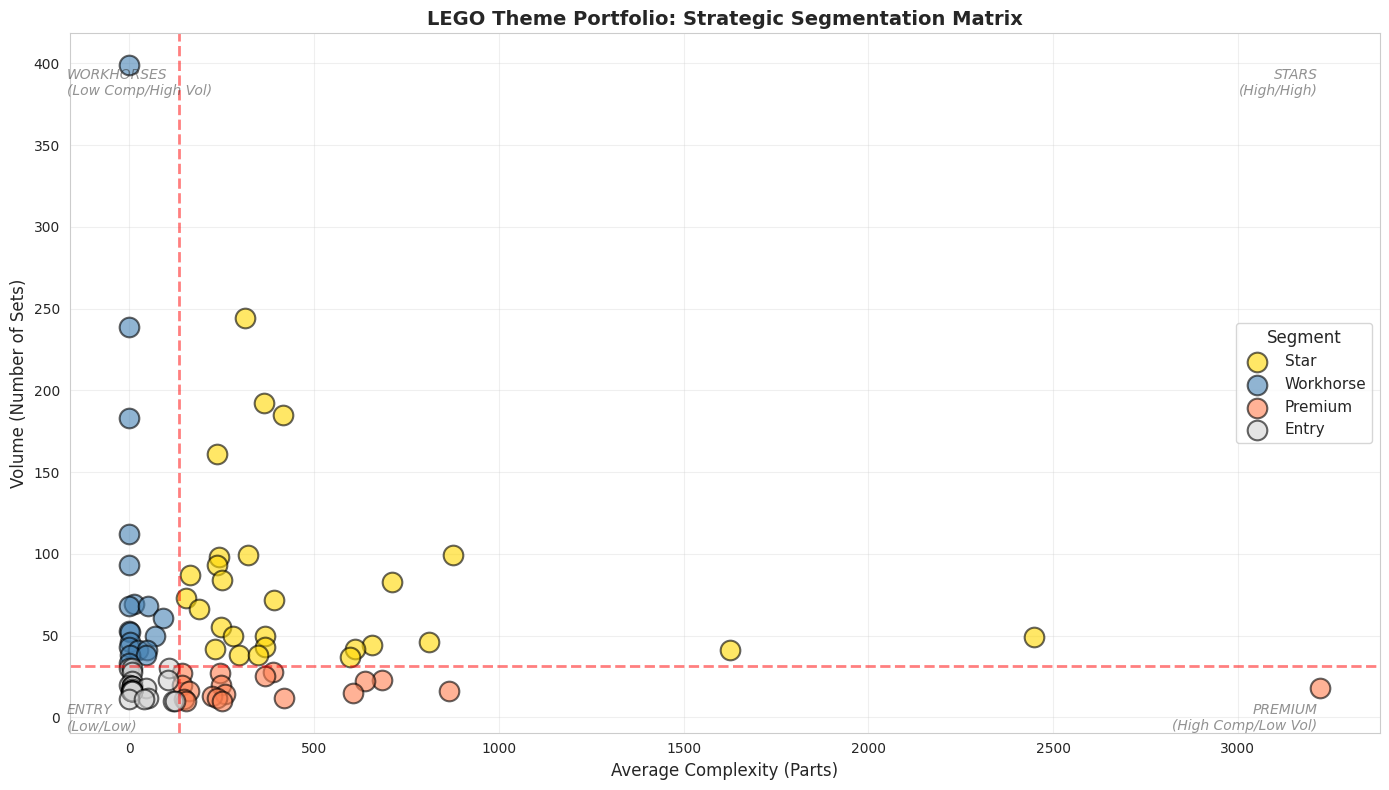

📊 Matrix shows strategic positioning based on volume vs complexity


In [15]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(14, 8))

# Color map for segments
colors = {'Star': 'gold', 'Workhorse': 'steelblue', 'Premium': 'coral', 'Entry': 'lightgray'}

for segment in df_segments['strategic_segment'].unique():
    segment_data = df_segments[df_segments['strategic_segment'] == segment]
    ax.scatter(segment_data['avg_parts'], segment_data['set_count'],
               label=segment, s=200, alpha=0.6, color=colors.get(segment, 'gray'),
               edgecolors='black', linewidths=1.5)

# Add quadrant lines
median_parts = df_segments['avg_parts'].median()
median_count = df_segments['set_count'].median()
ax.axvline(median_parts, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax.axhline(median_count, color='red', linestyle='--', alpha=0.5, linewidth=2)

# Labels
ax.set_xlabel('Average Complexity (Parts)', fontsize=12)
ax.set_ylabel('Volume (Number of Sets)', fontsize=12)
ax.set_title('LEGO Theme Portfolio: Strategic Segmentation Matrix', fontsize=14, fontweight='bold')
ax.legend(title='Segment', fontsize=11, title_fontsize=12)
ax.grid(True, alpha=0.3)

# Quadrant labels
ax.text(ax.get_xlim()[1] * 0.95, ax.get_ylim()[1] * 0.95, 'STARS\n(High/High)',
        ha='right', va='top', fontsize=10, style='italic', alpha=0.5)
ax.text(ax.get_xlim()[0] * 1.05, ax.get_ylim()[1] * 0.95, 'WORKHORSES\n(Low Comp/High Vol)',
        ha='left', va='top', fontsize=10, style='italic', alpha=0.5)
ax.text(ax.get_xlim()[1] * 0.95, ax.get_ylim()[0] * 1.05, 'PREMIUM\n(High Comp/Low Vol)',
        ha='right', va='bottom', fontsize=10, style='italic', alpha=0.5)
ax.text(ax.get_xlim()[0] * 1.05, ax.get_ylim()[0] * 1.05, 'ENTRY\n(Low/Low)',
        ha='left', va='bottom', fontsize=10, style='italic', alpha=0.5)

plt.tight_layout()
plt.show()

print("📊 Matrix shows strategic positioning based on volume vs complexity")

---

## 6. Key Findings & Strategic Recommendations

### Business Intelligence Summary

In [16]:
print("="*80)
print("📊 BUSINESS INTELLIGENCE - STRATEGIC INSIGHTS")
print("="*80)

print("\n1️⃣ MARKET DYNAMICS:")
top_theme_2024 = df_market_share[df_market_share['year'] == 2024].iloc[0]
print(f"   • 2024 market leader: {top_theme_2024['theme']}")
print(f"   • Market share: {top_theme_2024['market_share_pct']:.1f}%")
print(f"   • Market concentration: Top 3 control {df_market_share[df_market_share['year'] == 2024].head(3)['market_share_pct'].sum():.1f}%")

print("\n2️⃣ PORTFOLIO PERFORMANCE:")
top_performer = df_scorecard.iloc[0]
print(f"   • Best overall theme: {top_performer['theme']}")
print(f"   • Performance score: {top_performer['overall_score']:.1f}/100")
print(f"   • Key strength: {['Longevity', 'Volume', 'Complexity'][np.argmax([top_performer['longevity_score'], top_performer['volume_score'], top_performer['complexity_score']])]}")

print("\n3️⃣ STRATEGIC SEGMENTATION:")
segment_dist = df_segments['strategic_segment'].value_counts()
print(f"   • Star themes: {segment_dist.get('Star', 0)} (high volume + complexity)")
print(f"   • Workhorse themes: {segment_dist.get('Workhorse', 0)} (high volume, accessible)")
print(f"   • Premium themes: {segment_dist.get('Premium', 0)} (niche, complex)")
print(f"   • Entry themes: {segment_dist.get('Entry', 0)} (starter products)")

print("\n4️⃣ HIERARCHY INSIGHTS:")
print(f"   • Root themes analyzed: {df_hierarchy['root_theme'].nunique()}")
print(f"   • Most successful sub-theme: {df_hierarchy.loc[df_hierarchy['set_count'].idxmax(), 'sub_theme']}")
print(f"   • Deepest hierarchy level: {df_hierarchy['level'].max()}")

print("\n" + "="*80)
print("💡 STRATEGIC RECOMMENDATIONS")
print("="*80)

print("\n1️⃣ PORTFOLIO OPTIMIZATION:")
print("   • Invest in 'Star' themes - highest ROI potential")
print("   • Maintain 'Workhorse' themes - volume drivers")
print("   • Differentiate 'Premium' themes - brand positioning")
print("   • Evaluate 'Entry' themes - gateway products")

print("\n2️⃣ GROWTH OPPORTUNITIES:")
print("   • Expand sub-themes under successful parent themes")
print("   • Increase complexity in high-volume themes")
print("   • Launch premium extensions of popular themes")

print("\n3️⃣ RISK MITIGATION:")
print("   • Diversify beyond top 3 themes (market concentration risk)")
print("   • Refresh aging theme portfolios")
print("   • Balance complexity across customer segments")

print("\n4️⃣ SQL TECHNIQUES DEMONSTRATED:")
print("   ✅ Recursive CTEs (hierarchical queries)")
print("   ✅ Multi-CTE complex analysis")
print("   ✅ Market share calculations with PARTITION BY")
print("   ✅ Composite scoring algorithms")
print("   ✅ Strategic segmentation with NTILE")
print("   ✅ Multi-dimensional classification")

print("\n" + "="*80)
print("✅ Business intelligence analysis complete!")
print("="*80)

📊 BUSINESS INTELLIGENCE - STRATEGIC INSIGHTS

1️⃣ MARKET DYNAMICS:
   • 2024 market leader: Bags, Totes, & Luggage
   • Market share: 7.5%
   • Market concentration: Top 3 control 18.7%

2️⃣ PORTFOLIO PERFORMANCE:
   • Best overall theme: Technic
   • Performance score: 95.0/100
   • Key strength: Volume

3️⃣ STRATEGIC SEGMENTATION:
   • Star themes: 27 (high volume + complexity)
   • Workhorse themes: 19 (high volume, accessible)
   • Premium themes: 19 (niche, complex)
   • Entry themes: 27 (starter products)

4️⃣ HIERARCHY INSIGHTS:
   • Root themes analyzed: 13
   • Most successful sub-theme: City
   • Deepest hierarchy level: 1

💡 STRATEGIC RECOMMENDATIONS

1️⃣ PORTFOLIO OPTIMIZATION:
   • Invest in 'Star' themes - highest ROI potential
   • Maintain 'Workhorse' themes - volume drivers
   • Differentiate 'Premium' themes - brand positioning
   • Evaluate 'Entry' themes - gateway products

2️⃣ GROWTH OPPORTUNITIES:
   • Expand sub-themes under successful parent themes
   • Increase


---

**Version:** 1.0  
**Author:** Rodion Barskov  
**Date:** January 2025  
**Focus:** Business Intelligence & Strategic Analysis  
**Database:** SQLite (Rebrickable API + ~10,000 LEGO sets)